## **CS510: Deep Learning HW1: FashionMNIST**<br>
Winter 2021, Portland State University<br>
Steve Braich

Assignment Description:<br>
https://web.cecs.pdx.edu/~singh/courses/winter21/dl/a2w21.pdf <br>
"*The goal of this assignment is to gain some experience with CNNs. You will use the CIFAR-10
dataset for all the experiments.*"<br>
...<br>

## **0.	Resources**

Github Repo:
 - https://github.com/steve3p0/cs510dl/tree/master/hw2

Sources:
 - PyTorch.org: TRAINING A CLASSIFIER<br>
   https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
   
 - Diving deep: convolution output channels<br>
   http://deepdive.nn.157239n.com/conv-kernel


###**Useful Libraries**<br>
Let's import some libraries that were are going to need.

In [1]:
%matplotlib inline

import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing import List, Any
import torch.nn.functional as F
# from misc import progress_bar
import tqdm

Here are some testing and visualization libraries we will be using.

In [2]:
import time
import time as timer
import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

###**Enable GPU (if available)**<br>
Enable the ability to toggle between CPU and GPU device runtimes.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"Type of Machine: {device}")

Type of Machine: cuda:0


###**Datasets**<br>
You will use the CIFAR-10 dataset for all the experiments.dataset on Kagggle: <br>
https://www.cs.toronto.edu/~kriz/cifar.html

## **1. Construct a simple LeNet CNN**
Construct a simple CNN that follows the architecture of LeNet. However, the images have 3 channels. The first kernel will be 6 5x5x3 kernels that takes us to 28x28x6. The remainder of the network is the same. Stride is 1 for convolution and 2 for pooling layers. You need to train the network for different choices of parameters: learning rate 0.1, 0.01, 0.001, activation function = sigmoid, Tanh, loss function = MSE, cross-entropy.

### LeNet-5 Cifar-10 Class Object

In [4]:
class Cifar10LeNet5(nn.Module):
    """ Model class object that recognizes Cifar-10 images based on a LeNet-5 Convolutional Neural Network using
    Implements part 1 and 2 of the assignment
    """

    def __init__(self, activation=nn.Tanh(), fc1_channels:int=16, kernel_size:int=5,
                 batch_size:int=4, batch_scalar:int=1, tiny:bool=False, num_workers:int= 2) -> None:
        """ Constructor to initialize functions, channels, kernerls, batches, etc.
        :param activation:   function used to activate a neuron in a network
        :param fc1_channels: number of input channels in 1st fully connected layer
        :param kernel_size:  filter weight and height dimensions
        :param batch_size:   size of a batch of samples run before an update to the weights
        :param batch_scalar: scales the training data batch size for quicker training
        :param tiny:         used to test the model, loads small subset of data
        :param num_workers:  number of worker processes to load the data
        """
        super().__init__()

        self.bind_data(activation=activation, batch_size=batch_size, batch_scalar=batch_scalar, tiny=tiny, num_workers=num_workers)

        self.kernel_size = kernel_size
        self.fc1_channels = fc1_channels

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,  kernel_size=kernel_size, stride=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=kernel_size, stride=1)

        self.fc1 = nn.Linear(kernel_size * kernel_size * fc1_channels, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.activation = activation

    def forward(self, x) -> Any:
        """ Feed Forward method: The forward function computes output Tensors from input Tensors.
        :param x:  Tensor: the linear combination of the values that come from the neurons of the previous layer
        :return:   Tensor: the linear combination of the values that come from the neurons of the previous layer
        """

        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))

        x = x.view(-1, self.kernel_size * self.kernel_size * self.fc1_channels)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x

    def fit(self, loss_function:nn.CrossEntropyLoss(), learn_rate:float=0.01, momentum:float = 0.0, epochs:int=10) -> None:
        """ Train a fully connected neural network classifier on a dataset of fashion images
        :param loss_function: loss function to minimize
        :param learn_rate: rate at which the network learns
        :param momentum: accelerates learning toward a global minimum
        :param epochs: number of iterations over the entire data to run
        :return: None
        """
        self.criterion = loss_function
        self.learn_rate = learn_rate
        self.momentum = momentum
        self.epochs = epochs

        optimizer = torch.optim.SGD(params=self.parameters(), lr=learn_rate, momentum=momentum)

        # Print Training Parameters
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {self.activation.__str__()}")
        print(f"Loss Function: {self.criterion.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Test  Samples: {len(self.data_test)}")
        print(f"Train Samples: {len(self.data_train)}")
        print(f"Epochs:        {epochs}")

        for epoch in range(1, epochs + 1):
            #running_loss = 0.0
            # for i, data in enumerate(self.train_loader, 0):
            loss = 0.0
            correct = 0
            total = 0
            predicted = 0

            for batch_id, (images, labels) in enumerate(self.train_loader):
                # zero the parameter gradients
                optimizer.zero_grad()

                # get the inputs; data is a list of [inputs, labels]
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = self(images)

                # Calculate accurracy
                predicted = torch.argmax(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Calculate loss
                # Check if MSE for one hot encoding:
                if self.criterion.__str__() == "MSELoss()":  # nn.MSELoss():
                    ones = torch.sparse.torch.eye(10).to(device)  # number of class class
                    labels = ones.index_select(0, labels)
                loss = self.criterion(outputs, labels)  # self.criterion.__str__()
                loss.backward()

                # Optimize parameters
                optimizer.step()

                self.train()

            accuracy = 100 * correct / total
            error = 100 - accuracy
            self.train_accuracy.append(accuracy)
            self.train_error.append(error)
            self.train_loss.append(loss.item())

            print(f"\nEpoch {epoch}/{epochs} ------------------------------------------------------------------------------------------")

            width = 20
            str_accur = f"Accuracy".center(width, ' ')
            str_error = f"Error".center(width, ' ')
            str_loss = f"Loss".center(width, ' ')
            print(f"         {str_accur}{str_error}{str_loss}")

            str_accur_fmt = f"{accuracy:.2f}%".center(width, ' ')
            str_error_fmt = f"{error:.2f}%".center(width, ' ')
            str_loss_fmt = f"{loss.item():.2f}".center(width, ' ')
            print(f" Train: ", end=' ')
            print(f"{str_accur_fmt}{str_error_fmt}{str_loss_fmt}")

            self.eval()
            self.test()
            self.train()

    def test(self, loss_function:Any = None) -> None:
        """ Evaluate a model based on accuracy, error rate, and loss.
        :return: None
        """

        if loss_function is not None:
            self.criterion = loss_function

        test_loss = 0.0
        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image, label = image.to(device), label.to(device)
                output = self(image)

                predicted = torch.argmax(input=output, dim=1)

                # Calculate loss
                if (batch_id / batch_length == 1):
                    # Check if MSE for one hot encoding:
                    if self.criterion.__str__() == "MSELoss()":  # nn.MSELoss():
                        ones = torch.sparse.torch.eye(10).to(device)  # number of class class
                        label_mse = ones.index_select(0, label)
                        loss = self.criterion(output, label_mse)
                    else:
                        loss = self.criterion(output, label)
                    self.test_loss.append(loss.item())
                    test_loss = loss.item()

                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        error = 100 - accuracy
        self.test_accuracy.append(accuracy)
        self.test_error.append(error)

        width = 20
        str_accur_fmt = f"{accuracy:.2f}%".center(width, ' ')
        str_error_fmt = f"{error:.2f}%".center(width, ' ')
        str_loss_fmt  = f"{test_loss:.2f}".center(width, ' ')
        print(f"  Test: ", end=' ')
        print(f"{str_accur_fmt}{str_error_fmt}{str_loss_fmt}")

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                # for i in range(10):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        class_str = ""
        class_acc = ""
        for i in range(10):
            class_str += f" {self.classes[i]}".rjust(5).ljust(10)
            class_acc += f" {100 * class_correct[i] / class_total[i]:.2f}%".rjust(5).ljust(10)
        print(class_str)
        print(class_acc)

    def bind_data(self, activation:Any, batch_size:int, batch_scalar:int, tiny:bool=False, num_workers:int=2) -> None:
        """ Bind all of the class data attributes
        :param activation:   function used to activate a neuron in a network
        :param batch_size:   size of a batch of samples run before an update to the weights
        :param batch_scalar: scales the training data batch size for quicker training
        :param tiny:         used to test the model, loads small subset of data
        :param num_workers:  number of worker processes to load the data
        :return: None
        """

        self.activation = activation
        self.criterion = None
        self.learn_rate = 0.0
        self.epochs = 0
        self.momentum = 0.0
        self.batch_size = batch_size
        self.batch_scalar = batch_scalar

        # results
        self.params = []
        self.train_accuracy = []
        self.train_error = []
        self.train_loss = []

        self.test_accuracy = []
        self.test_error = []
        self.test_loss = []

        self.activation_hooks = {}

        self.batch_size   = batch_size
        self.batch_scalar = batch_scalar

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        self.data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

        # scale the training data (for faster testing of train)
        if tiny:
            self.data_test  = torch.utils.data.Subset(self.data_test, range(1000))
            self.data_train = torch.utils.data.Subset(self.data_train, range(6000))
        self.test_loader  = torch.utils.data.DataLoader(dataset=self.data_test,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=batch_size, shuffle=True,  num_workers=num_workers)


Helper methods used in displaying visualizations.

In [5]:
def display_visuals(model:Any):

    # Plot Error
    param_title = f"φ: {model.activation.__str__()}, λ: {model.criterion.__str__()}, η: {model.learn_rate}"
    plt.plot(np.arange(model.epochs), model.train_error, label='Train Error')
    plt.plot(np.arange(model.epochs), model.test_error, label='Test Error')
    plt.title(f"Error Rate\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.clf()

    # Plot Cross Entropy Loss
    param_title = f"φ: {model.activation.__str__()}, λ: {model.criterion.__str__()}, η: {model.learn_rate}"
    plt.plot(np.arange(model.epochs), model.train_loss, label='Train Loss')
    plt.plot(np.arange(model.epochs), model.test_loss, label='Test Loss')
    plt.title(f"Loss: {model.criterion.__str__()}\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.clf()

### **a. LeNet-5 Training Variations**

Submit plots of training error vs epoch and test error vs epoch for each combination of parameters. 

Describe the reasons for what you observe.

**Answer:**<br>
*The best performing model used the Tanh Activation function, with Cross Entropy Loss and a learning rate of 0.001.   This demonstrates that Tanh, with its upper and lower bounds of 1 and -1, respectively, was able to outperform
Sigmoid by minimizing loss with a slower learning rate of 0.001.  Sigmoid seemed to suffer across the board. With Cross Entropy loss, and a learning rate of 0.001, Sigmoid suffered from unstable gradients.  Even with more stable gradients with using a learning rate of 0.01, its test error rate never dipped below 40%. And when it did hit 40%, the graph is obvious that the model does not generalize well, as the error rate plunged
for training, but not for testing data.  Several of the Sigmoid models, especially the ones with lower learning rates appear to suffer from vanishing gradients.*



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~ TestCifar10Model.test_part2_all: 02/17/2021 06:03:08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




####################################################################################################
CASE: 01 Training Started: 02/17/2021 06:03:08
####################################################################################################
Files already downloaded and verified
Files already downloaded and verified
Learning Rate: 0.1
Activation:    Sigmoid()
Loss Function: CrossEntropyLoss()
Batch Size:    4
Test  Samples: 10000
Train Samples: 50000
Epochs:        30

Epoch 1/30 ------------------------------------------------------------------------------------------
               Accuracy             Error                Loss        
 Train:         9.88%               90.12%               2.26       

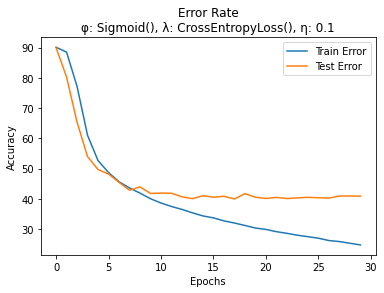

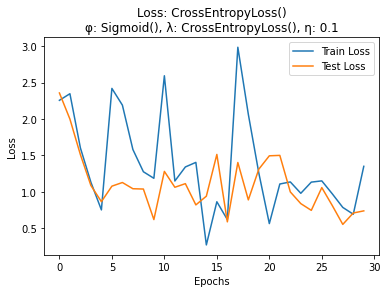

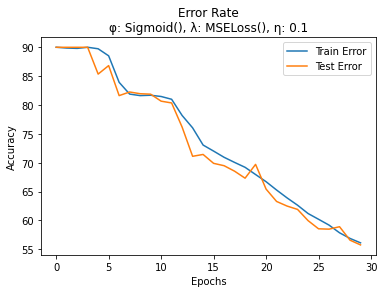

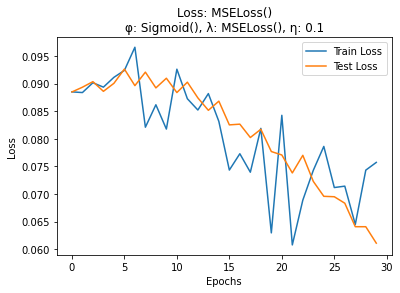

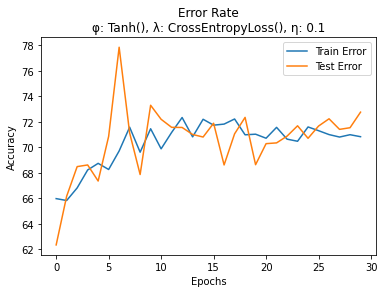

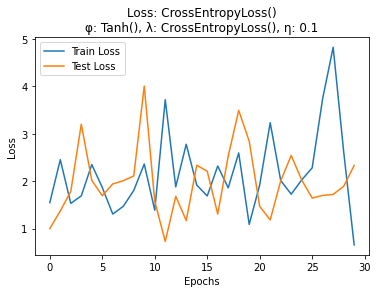

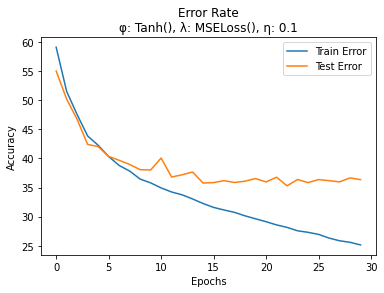

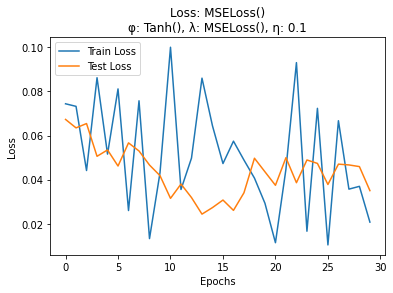

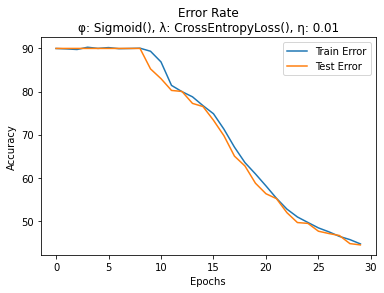

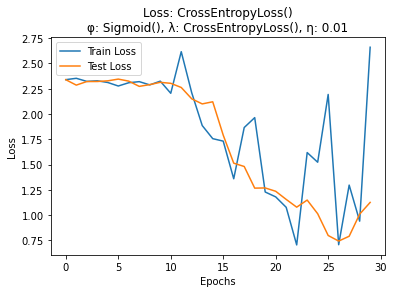

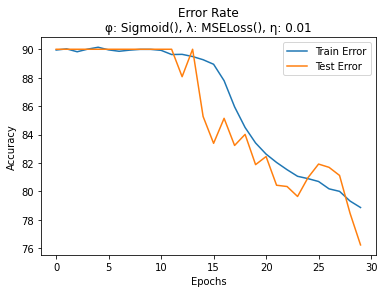

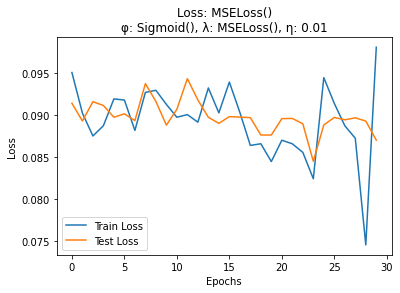

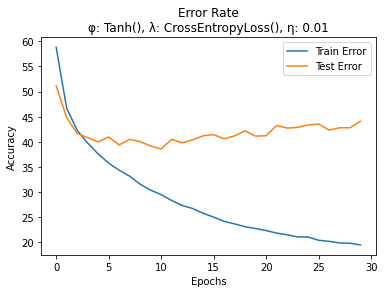

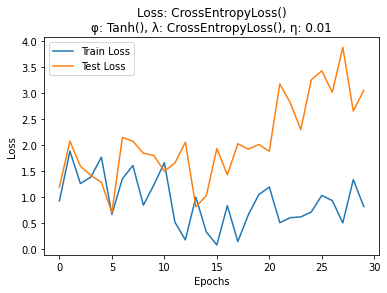

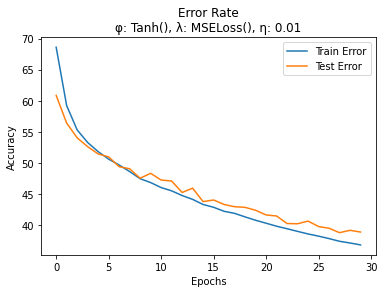

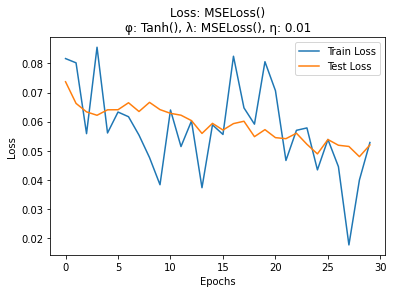

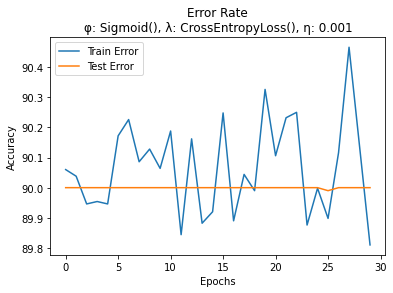

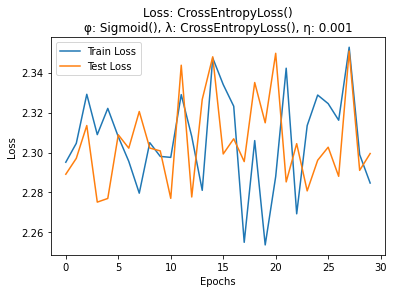

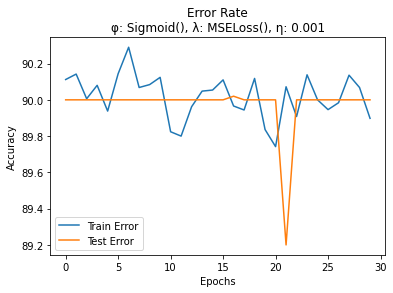

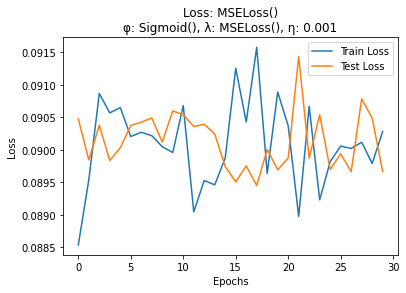

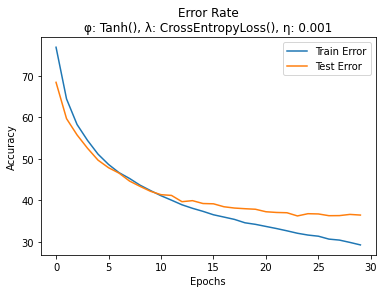

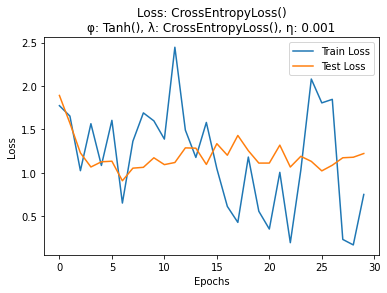

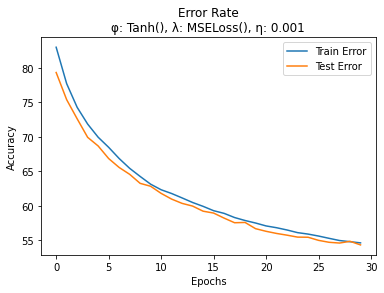

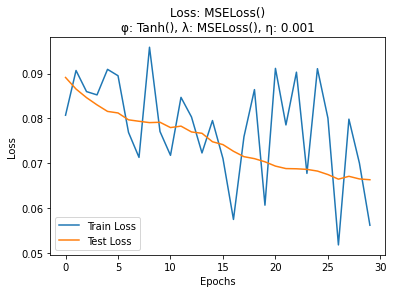

<Figure size 432x288 with 0 Axes>

In [6]:
def test_part1_all(tiny:bool = True, epochs:int = 2):

    start = timer.time()
    timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    print()
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"~~~~ TestCifar10Model.test_part2_all: {timestamp_pretty}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("\n\n")

    num_workers = 0

    kernel_size  = 5
    fc1_channels = 16
    batch_size   = 4
    batch_scalar = 1
    momentum     = 0

    # Full Testing
    params = {
        'activation': [nn.Sigmoid(), nn.Tanh()],
        'loss_function': [nn.CrossEntropyLoss(), nn.MSELoss()],
        'learn_rate': [0.1, 0.01, 0.001],
    }

    i = 0
    for learn_rate in params['learn_rate']:
        for activation in params['activation']:
            for loss_function in params['loss_function']:
                i += 1
                start_iteration = timer.time()
                start_train = datetime.datetime.now()
                start_train_str = start_train.strftime("%m/%d/%Y %H:%M:%S")
                print()
                print("####################################################################################################")
                print(f"CASE: {i:02d} Training Started: {start_train_str}")
                print("####################################################################################################")

                # Train the model
                model = Cifar10LeNet5(activation=activation, fc1_channels=fc1_channels, kernel_size=kernel_size,
                                            batch_size=batch_size, batch_scalar=batch_scalar,
                                            tiny=tiny, num_workers=num_workers).to(device)
                model.fit(loss_function=loss_function, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

                display_visuals(model=model)

    elapsed = (time.time() - start)
    print(f"Total Elapsed Time: {str(timedelta(seconds=elapsed))}\n\n")


test_part1_all(tiny=False, epochs=30)


### **b. LeNet-5 Feature Maps**

b.	For one trained network and parameter choice, display feature maps of 10 images at the last convolution layer. What has your network learned?

**Answer:**<br>
*LeNet-5 was originally hand-designed in 1995 by Yann LeCun using local connections to restrict the computation and memory complexity and to break symmetry. When the LeNet-5 architecture was published by LeCun in 1995, he was restricted by the available hardware at time.  He hand-designed LeNet-5 by using local connections to restrict the computation and memory complexity and to break symmetry.  In 2021 we have access to GPUs and PyTorch’s unbounded Conv2d object that maps all input features to all output features.  Furthermore, new methods in breaking symmetry include random weight initialization, dropouts, and others.*

## **2. 3x3 Kernels**
Select ReLU, learning rate of 0.001, cross-entropy loss. Change the network to use 3x3 kernels for both convolutions rather than 5x5. Same pooling.

### **a. Plots and Results**

Plot the error (test, train) vs epoch and discuss how your results differ from the previous network.

**Answer:**<br>
*Actually, we get very similar results with part 1’s best model using Tanh, but with the same loss function and learning rate as this one using ReLU.  We see only marginal improvement with a 2.5% reduction in the error rate. One noticeable difference is that there is a gap in the error rate between the test and train, suggesting that this ReLU model does not generalize as well as the Tanh one.*

*I did see slightly less erratic test loss reported for Tanh than with ReLu.  However, the testing loss reported by this model seemed to mimic the behavior of its training loss more than the previous model did.*

def test_part2_relu_cel_k3(tiny:bool = True, epochs:int = 2):

    start = timer.time()
    timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    print("####################################################################################################")
    print(f"TestCifar10Model.test_part2_relu_cel_k3: {timestamp_pretty}")
    print("####################################################################################################")

    num_workers = 0

    activation   = nn.ReLU()
    fc1_channels = 64
    kernel_size  = 3
    batch_size   = 4
    batch_scalar = 1

    loss_function = nn.CrossEntropyLoss()
    learn_rate    = 0.001
    momentum      = 0

    # Train the model
    model = Cifar10LeNet5(activation=activation, fc1_channels=fc1_channels, kernel_size=kernel_size,
                                batch_size=batch_size, batch_scalar=batch_scalar,
                                tiny=tiny, num_workers=num_workers).to(device)
    model.fit(loss_function=loss_function, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

    display_visuals(model=model)

    elapsed = (time.time() - start)
    print(f"Time taken: {str(timedelta(seconds=elapsed))} Elapsed\n\n")

test_part2_relu_cel_k3(tiny=False, epochs=30)

####################################################################################################
TestCifar10Model.test_part2_relu_cel_k3: 02/17/2021 13:37:54
####################################################################################################
Files already downloaded and verified
Files already downloaded and verified
Learning Rate: 0.001
Activation:    ReLU()
Loss Function: CrossEntropyLoss()
Batch Size:    4
Test  Samples: 10000
Train Samples: 50000
Epochs:        30

Epoch 1/30 ------------------------------------------------------------------------------------------
               Accuracy             Error                Loss        
 Train:         10.63%              89.37%               2.31        
  Test:         17.72%              82.28%               2.31        
 plane      car      bird       cat      deer       dog      frog      horse     ship      truck    
 78.70%    0.10%     0.00%     0.00%     43.80%    0.00%     0.00%     1.00%     4.70%     48

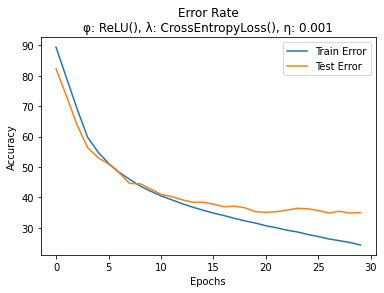

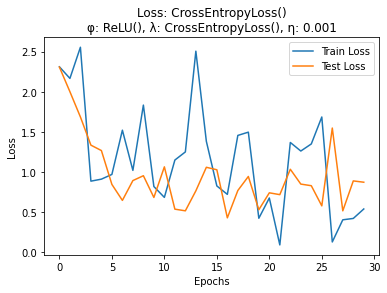

<Figure size 432x288 with 0 Axes>

In [8]:
## **3. CNN with 5 Layers**
Build a CNN with 5 convolution layers with 3x3 kernels and corresponding 2x2 average pooling with stride 1. Use padding at each convolution layer so that the size of the output matches the input after each convolution layer. Train the network for any choice of model parameters.

### LeNet-5 Cifar-10 Class Object

In [9]:
class Cifar10Cnn5(nn.Module):
    """ Model class object that recognizes Cifar-10 images based on a 5 layer Convolutional Neural Network using
    Batched Normalization and drop outs. Implements part 3 of the assignment
    """

    def __init__(self, activation=nn.ReLU(), batch_size:int=100, batch_scalar:int=1, kernel_size:int=3,
                 tiny:bool=False, num_workers:int=2):
        """ Constructor to initialize functions, channels, kernerls, batches, etc.
        :param activation:   function used to activate a neuron in a network
        :param batch_size:   size of a batch of samples run before an update to the weights
        :param batch_scalar: scales the training data batch size for quicker training
        :param kernel_size:  filter weight and height dimensions
        :param tiny:         used to test the model, loads small subset of data
        :param num_workers:  number of worker processes to load the data
        """
        super().__init__()

        self.bind_data(activation=activation, batch_size=batch_size, batch_scalar=batch_scalar, tiny=tiny, num_workers=num_workers)

        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=32,  kernel_size=kernel_size, padding=1) # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,  kernel_size=kernel_size, padding=1) # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,  kernel_size=kernel_size, padding=1) # 16x16 -> 16x16
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64,  kernel_size=kernel_size, padding=1) # 16x16 -> 8x8
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, padding=1) # 8x8 -> 4x4
        self.pool = nn.MaxPool2d(2)
        self.relu = self.activation
        self.logSoftmax = nn.LogSoftmax(1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(128 * 4 * 4, 300)
        self.fc2 = nn.Linear(300, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x) -> None:
        """ Feed Forward method: The forward function computes output Tensors from input Tensors.
        :param x:  Tensor: the linear combination of the values that come from the neurons of the previous layer
        :return:   Tensor: the linear combination of the values that come from the neurons of the previous layer
        """
        x = self.batchnorm1(self.pool(self.relu(self.conv2(self.relu(self.conv1(x))))))
        x = self.batchnorm2(self.pool(self.relu(self.conv4(self.relu(self.conv3(x))))))
        x = self.pool(self.relu(self.conv5(x)))
        x = self.dropout(x.contiguous().view(-1, 128 * 4 * 4))
        x = self.dropout(self.relu(self.fc1(x)))

        return self.logSoftmax(self.fc2(x))

    def fit(self, loss_function:nn.CrossEntropyLoss(), learn_rate:float=0.003, weight_decay:float=1e-5, epochs:int = 10) -> None:
        """ Train a fully connected neural network classifier on a dataset of fashion images
        :param loss_function: loss function to minimize
        :param learn_rate: rate at which the network learns
        :param momentum: accelerates learning toward a global minimum
        :param epochs: number of iterations over the entire data to run
        :return: None
        """
        self.criterion = loss_function
        self.learn_rate = learn_rate
        self.weight_decay = weight_decay
        self.epochs = epochs

        optimizer = optim.Adam(self.parameters(), self.learn_rate, weight_decay=weight_decay)

        # Print Training Parameters
        print(f"Learning Rate: {self.learn_rate}")
        print(f"Activation:    {self.activation.__str__()}")
        print(f"Loss Function: {self.criterion.__str__()}")
        # print(f"Optimizer:     {optimizer.__name__}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Batch Scalar:  {self.batch_scalar}")
        print(f"Test  Samples: {len(self.data_test)}")
        print(f"Train Samples: {len(self.data_train)}")
        print(f"Epochs:        {self.epochs}")

        for epoch in range(epochs):
            loss = 0.0
            correct = 0
            total = 0
            predicted = 0

            for images, labels in self.train_loader:

                # zero the parameter gradients
                optimizer.zero_grad()

                # get the inputs; data is a list of [inputs, labels]
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = self(images)

                # Calculate accurracy
                predicted = torch.argmax(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Minimize Cost Function
                # loss = self.criterion(self(images), labels)
                loss = self.criterion(outputs, labels)
                loss.backward()

                # Optimize parameters
                optimizer.step()

            accuracy = 100 * correct / total
            error = 100 - accuracy
            self.train_accuracy.append(accuracy)
            self.train_error.append(error)
            self.train_loss.append(loss.item())

            print(f"\nEpoch {epoch + 1}/{epochs} ------------------------------------------------------------------------------------------")

            width = 20
            str_accur = f"Accuracy".center(width, ' ')
            str_error = f"Error".center(width, ' ')
            str_loss = f"Loss".center(width, ' ')
            print(f"         {str_accur}{str_error}{str_loss}")

            str_accur_fmt = f"{accuracy:.2f}%".center(width, ' ')
            str_error_fmt = f"{error:.2f}%".center(width, ' ')
            str_loss_fmt = f"{loss.item():.2f}".center(width, ' ')
            print(f" Train: ", end=' ')
            print(f"{str_accur_fmt}{str_error_fmt}{str_loss_fmt}")

            self.eval()
            self.test()
            self.train()

    def test(self) -> None:
        """ Evaluate a model for accuracy, error rate, and loss
        :return: None
        """

        self.eval()
        loss = 0
        batch_loss = 0
        correct = 0
        predicted = 0
        total = 0

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for batch_id, (images, labels) in enumerate(self.test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)

                # accuracy
                predicted = torch.argmax(input=outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # class accuracy
                c = (predicted == labels).squeeze()
                # for i in range(10):
                for i in range(self.batch_size):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

                # loss
                if batch_id % self.batch_size == 0:
                    loss = self.criterion(outputs, labels)
                    self.test_loss.append(loss.item())
                batch_loss += loss.item()

        accuracy = 100 * correct / total
        error = 100 - accuracy
        batch_loss = batch_loss /(self.batch_size)

        self.test_accuracy.append(accuracy)
        self.test_error.append(error)

        width = 20
        str_accur_fmt = f"{accuracy:.2f}%".center(width, ' ')
        str_error_fmt = f"{error:.2f}%".center(width, ' ')
        # str_loss_fmt  = f"{loss:.2f}".center(width, ' ')
        str_loss_fmt  = f"{batch_loss:.2f}".center(width, ' ')
        print(f"  Test: ", end=' ')
        print(f"{str_accur_fmt}{str_error_fmt}{str_loss_fmt}")

        # Print Class Accuracy
        class_str = ""
        class_acc = ""
        for i in range(10):
            blah = f"classes[i]"
            class_str += f" {self.classes[i]}".rjust(5).ljust(10)
            class_acc += f" {100 * class_correct[i] / class_total[i]:.2f}%".rjust(5).ljust(10)
        print(class_str)
        print(class_acc)

    def bind_data(self, activation:Any, batch_size:int, batch_scalar:int, tiny:bool=False, num_workers:int=2):
        """ Bind all of the class data attributes
        :param activation:   function used to activate a neuron in a network
        :param batch_size:   size of a batch of samples run before an update to the weights
        :param batch_scalar: scales the training data batch size for quicker training
        :param tiny:         used to test the model, loads small subset of data
        :param num_workers:  number of worker processes to load the data
        :return: None
        """

        self.activation = activation
        self.criterion = None
        self.learn_rate = 0.0
        self.epochs = 0
        self.momentum = 0.0
        self.batch_size = batch_size
        self.batch_scalar = batch_scalar

        # results
        self.params = []
        self.train_accuracy = []
        self.train_error = []
        self.train_loss = []

        self.test_accuracy = []
        self.test_error = []
        self.test_loss = []

        self.means = torch.Tensor([0.4914, 0.4822, 0.4465])
        self.means = self.means.unsqueeze(-1).unsqueeze(-1).expand(-1, 32, 32)
        self.stds = torch.Tensor([0.2470, 0.2435, 0.2616])
        self.stds = self.stds.unsqueeze(-1).unsqueeze(-1).expand(-1, 32, 32)

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
                                         transforms.ToTensor(), transforms.Normalize(self.means, self.stds)])

        self.data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        self.data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

        # scale the training data (for faster testing of train)
        if tiny:
            self.data_test  = torch.utils.data.Subset(self.data_test, range(8000))
            self.data_train = torch.utils.data.Subset(self.data_train, range(30000))

        self.test_loader  = torch.utils.data.DataLoader(self.data_test,  batch_size=self.batch_size,
                                                        shuffle=True, num_workers=num_workers)
        self.train_loader = torch.utils.data.DataLoader(self.data_train, batch_size=self.batch_size * self.batch_scalar,
                                                        shuffle=True, num_workers=num_workers)

####################################################################################################
TestCifar10Model.test_part3_5cnn: 02/17/2021 14:30:07
####################################################################################################
Files already downloaded and verified
Files already downloaded and verified
Learning Rate: 0.001
Activation:    ReLU()
Loss Function: NLLLoss()
Batch Size:    100
Batch Scalar:  10
Test  Samples: 10000
Train Samples: 50000
Epochs:        30

Epoch 1/30 ------------------------------------------------------------------------------------------
               Accuracy             Error                Loss        
 Train:         39.58%              60.42%               1.33        
  Test:         46.99%              53.01%               1.38        
 plane      car      bird       cat      deer       dog      frog      horse     ship      truck    
 60.90%    36.90%    42.50%    43.90%    35.80%    48.90%    73.30%    36.40%    47.50%  

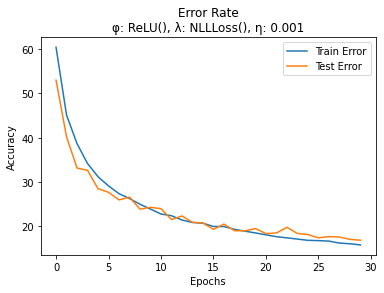

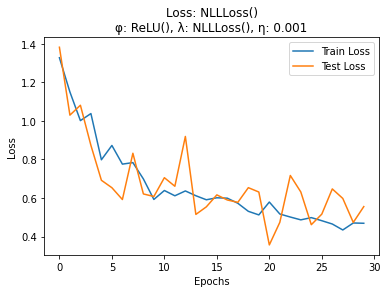

<Figure size 432x288 with 0 Axes>

In [12]:
def test_part3_5cnn(tiny:bool = True, epochs:int = 2):

    start = timer.time()
    timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    print("####################################################################################################")
    print(f"TestCifar10Model.test_part3_5cnn: {timestamp_pretty}")
    print("####################################################################################################")

    batch_size   = 100
    batch_scalar = 10
    num_workers  = 0

    kernel_size   = 3
    learn_rate    = 0.001
    weight_decay  = 1e-5
    activation    = nn.ReLU()
    loss_function = nn.NLLLoss()

    model = Cifar10Cnn5(activation=activation, batch_size=batch_size, batch_scalar=batch_scalar,
                        kernel_size=kernel_size, tiny=tiny, num_workers=num_workers).to(device)

    model.fit(loss_function=loss_function, learn_rate=learn_rate, weight_decay=weight_decay, epochs=epochs)
    display_visuals(model=model)
    # model.displayConvOutputs(torch.normal(0, 1, (1, 3, 32, 32)))

    elapsed = (time.time() - start)
    print(f"\nTime taken: {str(timedelta(seconds=elapsed))} Elapsed\n\n")

test_part3_5cnn(tiny=False, epochs=30)

### **a. Training Time**
How long did it take to train? Why?

**Answer:**<br>
*It took approximately 8 minutes to train with 30 epochs.  This was less than half of what all the other models took to train (17 minutes average).  This was due to using batched normalization.*

### **b. Comparision of all three Networks**
How does the accuracy of this network compare against the previous two? Explain.

**Answer:**<br>
*We saw significant improvement with this model using batched normalization, ReLu, minimizing log likelihood loss with a learning rate of 0.001, and the use of dropouts.*